# Incorporating fine grained/additional labels with custom loss function in Google Contrail competition

## The competition

[Google Research - Identify Contrails to Reduce Global Warming](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/overview) was hosted on Kaggle and tasked competitors to create a segmentation model which creates a pixel mask marking contrails on satellite data.       
The quotes and images linked here are taken from Google's accompanying material.[[1]](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming)[[2]](https://www.kaggle.com/code/inversion/visualizing-contrails)

![contrails](https://storage.googleapis.com/kaggle-media/competitions/Google-Contrails/waterdroplets.png)

Here is an example of a satellite image(left) and its corresponding mask(right).
![masks](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F59561%2F590a0bc76044a4ceb71368cf3b62412e%2Fcontrails_600.png?generation=1683669162469942&alt=media)



### Data

While the image above displays a false-color satellite picture —where different spectral bands are assigned artificial colors to enhance specific features— and its corresponding mask, each datapoint in the dataset includes more extensive information.

Per data-point in the training data set, there are: 
- Satellite images of eight timesteps. Four before timesteps, the timestep which is annotated (let's call it $t_0$), and three after timesteps
- Nine infrared channels per timestep/image
- The ground truth pixel mask
- Four or more individual pixel masks
- Metadata information ("timestamps and the projection parameters to reproduce the satellite images")

The validation data set lacks the individual pixel masks, otherwise it's the same.

The test dataset lacks the metadata information.

The data can be found [here](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data)

### Corresponding Labels
Non-experts were provided with [labeling instructions](https://storage.googleapis.com/goes_contrails_dataset/20230419/Contrail_Detection_Dataset_Instruction.pdf) and tasked to annotate timestep $t_0$.
They were provided with the ash colour version image of each timestep. These ash colour scheme images are false color rgb images computed from the infrared bands 11,13,15, the other six bands are excluded. The previous image was also in this colour scheme.    

The ground truth mask is computed from the individual annotators masks like this:    
> Ground truth was determined by (generally) 4+ different labelers annotating each image. Pixels were considered a contrail when >50% of the labelers annotated it as such. Individual annotations (human_individual_masks.npy) as well as the aggregated ground truth annotations (human_pixel_masks.npy) are included in the training data. The validation data only includes the aggregated ground truth annotations.

For each datapoint, the aggregated ground truth mask as well as all the individual masks are provided.

### Evaluation metric

> This competition is evaluated on the global Dice coefficient.

# My experiment: Utilizing the additional Label information
## Intuition
Lets have a look at all the provided  individual masks of one datapoint. For this datapoint, there are four individual masks.

**Ground truth** (The displayed images utilize the ash colour scheme.)    
<img src="images\ground_truth.png" />    
    
**Individual masks**    
<img src="images\different_masks.png" />



Comparing the different masks, we can see that there is a notable difference between each individual mask, and as result also between each individual mask and the ground truth mask.  
Due to this, I felt that including the individual annotators mask in another way than only via their majority vote should provide the model with more information by providing additional context and result in an improved perfomance.

I wanted to test this idea with a simple way of incorperating additional label information: 
Utilzing for the training loss function not only the majority vote mask(=ground-truth), but additionally the union of all individual masks, which is a mask that contains all the pixel coordinates which are present in at least one of the individual masks.
Then I will utilize this additional mask by adjusting the loss funtion to punishing false positives (of the ground truth mask) less if they are inside this union mask.
The reasoning being, that a pixel where a human annotator identified a contrail should more often then not be a better guess than a pixel where no human annotator identiefied a contrail. 

Here we can see this union_mask in contrast to the ground truth mask, which are both created from the individual masks.

**All Individual masks combined**    
<img src="images\ground_truth mask.png" />

**All Individual masks combined**    
<img src="images\union_mask.png" />
To implement my idea, I will change from using as loss function (in training) only the $F_{1}$ loss on the ground truth mask to combining two loss functions:     
1)a $F_{1}$ or $F_{\beta}$ loss on the ground truth mask as well as       
2)a $F_{\beta}$ loss on the union of all individual masks.


$weight_{\text{ground-truth}} \cdot F_{\beta\text{-ground-truth}}(\text{predicted mask, ground truth mask}) + (1 - weight_{\text{ground-truth}}) \cdot F_{\beta\text{-union}}(\text{predicted mask, union of individual masks})$

The details of the loss function are explained in the implementation block below.

Lets test which loss function hyperparamters $\beta_{\text{ground-truth}}$, $\beta_{\text{union}}$ , $weight_{\text{ground-truth}}$
 perform the best and how good they perform!
## Implementation


I build upon the baseline model of Egor Trushins' public Kaggle Notebook [[GR-ICRGW] PL Pipeline Improved](https://www.kaggle.com/code/egortrushin/gr-icrgw-pl-pipeline-improved), which uses [pytorch lightning](https://lightning.ai/pytorch-lightning) as well as [segmetation_models_pytorch](https://smp.readthedocs.io/en/latest/) and continue to only take into account the ash colour image of timestep $t_0$.    
Using only the ash colour images seemed to work best for most kaggle users, probably because the task is not to spot contrails, but to predict where the human labelers spotted them.   

The segmentation model I use is [Unet](https://smp.readthedocs.io/en/latest/models.html#unet) with [timm-ResNeSt26d](https://smp.readthedocs.io/en/latest/encoders_timm.html) Encoder with pretrained ImageNet weigths.  

Besides implementing my custom loss function, I also need to adjust the dataset such that it additionally provides the union of all individual mask for use in the loss function in the training split.

### Custom loss

I replace the F-1/Dice loss on the ground truth mask used currently as loss function in training. For validation, I will continue to use The Dice loss.
For training, I construct a custom loss function, which weigths two $F_\beta$ loss functions, one on the ground truth mask and the other one on the union of all individual masks.
For that, I utilize the [Tversky loss](https://smp.readthedocs.io/en/latest/losses.html#tverskyloss) function implemented in the SMP package.  With the constraint $\alpha + \beta = 1$, the tversky loss becomes equal to the $F_\beta$ loss.   

The training loss will be computed like this:  
$weight_{\text{ground-truth}} \cdot F_{\beta\text{-ground-truth}}(\text{predicted mask, ground truth mask}) + (1 - weight_{\text{ground-truth}}) \cdot F_{\beta\text{-union}}(\text{predicted mask, union of individual masks})$  


```
loss_ground_truth = smp.losses.TverskyLoss("binary", alpha=self.alpha, beta=self.beta)(preds, label_gt)
loss_union = smp.losses.TverskyLoss("binary", alpha=self.alpha_union, beta=self.beta_union)(preds, label_union)
loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"]) + torch.mul(loss_union, self.config["weight_union"])
```
(See "Lightning Module Custom Tversky Loss" in the Code section below)   

The hyperparameters to choose are: (i) $\beta_{\text{ground-truth}}$ for comparing the predicted mask with the ground truth mask (ii) $\beta_{\text{union}}$ for comparing the predicted mask with the union of all indivudual masks (iii) $weight_{\text{ground-truth}}$ to determine which part of the loss should be weighted more.   

### Dataset adjustment
Additionally, I adjust the dataset `__getitem__` function, such that it returns the union of all individual masks in addition to the ground truth mask, if it is used for training. 
```
label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
labelers = label_indiv[1,1,:].shape[0]
label_union = torch.zeros([256, 256])
for i in range(labelers):
    label_i = label_indiv[:, :,i]
    label_union[label_i[:, :] == 1] = 1  
```
(See "Lightning Module Custom Tversky Loss" in the Code section below)   

I then sample loss hyper-parameter values around the values that I expect to perform well.



# Code
## Imports

In [3]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import griddata
import segmentation_models_pytorch as smp
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
from torchmetrics.functional import dice
from torch.utils.data import Dataset, DataLoader
import warnings
import yaml
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
# from pprint import pprint

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')


## Config
The config is used by the dataset and the lightning module to set and load the parameters of model, trainer and dataset.  
The loss function hyperparameters are saved here as well, but changed via the training function parameter later per model.

In [11]:
%%writefile resnest26d_ash_attention_sample_loss.yaml


output_dir: "./metrics"

seed: 42

train_bs: 68
valid_bs: 128
workers: 6

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 5
    verbose: 1

trainer:
    max_epochs: 30
    min_epochs: 24
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    alpha: -1.0
    beta: -1.0
    alpha_union: -1.0
    beta_union: -1.0
    weight_union: -1.0
    weight_ground_truth: -1.0
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    encoder_depth: 5
    loss_smooth: 1.0
    decoder_attention_type: "scse"
    image_size: 384
    optimizer_params:
        lr: 0.0005
        weight_decay: 0.0
        eps: 1.0e-6
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776601
                patience: 4
                verbose: True

Overwriting resnest26d_ash_attention_sample_loss.yaml


In [7]:
with open("resnest26d_ash_attention_sample_loss.yaml", "r") as file_obj:
    resnest26d_ash_attention_sample_loss = yaml.safe_load(file_obj)

## Dataset
For the training loss and therefore in the training split of the dataset, I need the union of all individual masks additionally to the ground truth mask.     
To do that, I adjust the `__getitem__` function in the following way:  
     
First, I create the union_mask from all the individual masks if `self.split` is `train`      
```
if self.split == "train":
    label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
    label = torch.Tensor(label).to(torch.int64)
    label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
    labelers = label_indiv[1,1,:].shape[0]
    label_union = torch.zeros([256, 256])
    for i in range(labelers):
        label_i = label_indiv[:, :,i]
        label_union[label_i[:, :] == 1] = 1 
```
And then, if `self.split` is `train`, return both masks instead of only the ground truth mask.
```
if self.split == "train":
    return img.float(), [label.float(),label_union.float()]
if self.split == "validation":
    return img.float(), label.float()
```

But first, let's set the data paths.

In [8]:
# Replace these with the actual data path for use
parent_dir = os.getcwd()
data_path_mf_train = os.path.join(parent_dir, "data_excerpt\\train\\")
data_path_mf_valid = os.path.join(parent_dir, "data_excerpt\\validation\\")
print(parent_dir)
print(data_path_mf_train)

c:\Git\Contrails
c:\Git\Contrails\data_excerpt\train\


In [9]:

class ContrailsDatasetMixed(Dataset):
    def __init__(self, split="train", mode="single", delta_t = 0):
        self.delta_t = delta_t
        self.split = split
        self.mode = mode
        self.path = (lambda x: data_path_mf_train if x == "train" else data_path_mf_valid)(self.split)
        self.examples = os.listdir(self.path)
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        if self.mode == "single":
            t_null = 4
            return false_color[..., t_null+self.delta_t]
        else:
            return false_color
    
    def __getitem__(self, index):
        path = f"{self.path}{self.examples[index]}"
        data = self.read_record(path)    
        img = self.get_false_color(data)
        if self.split == "validation":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
        if self.split == "train":
            label = np.load(os.path.join(path, "human_pixel_masks.npy")).squeeze()
            label = torch.Tensor(label).to(torch.int64)
            label_indiv = np.load(os.path.join(path, "human_individual_masks.npy")).squeeze()
            labelers = label_indiv[1,1,:].shape[0]
            label_union = torch.zeros([256, 256])
            for i in range(labelers):
                label_i = label_indiv[:, :,i]
                label_union[label_i[:, :] == 1] = 1   

        if self.mode == "single":
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1).squeeze()
        else:
            img = torch.tensor(np.reshape(img, (256, 256, 3, -1))).to(torch.float32).permute(3, 2, 0, 1)

        img = self.normalize_image(img)

        if self.split == "train":
            return img.float(), [label.float(),label_union.float()]
        if self.split == "validation":
            return img.float(), label.float()

        return img.float()
    j
    def __len__(self):
        return len(self.examples)

### Visualize the data and the two masks
(Following code block is a slightly adjusted version of Googles [accompanying notebook](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data).)

tensor(101821.9609)


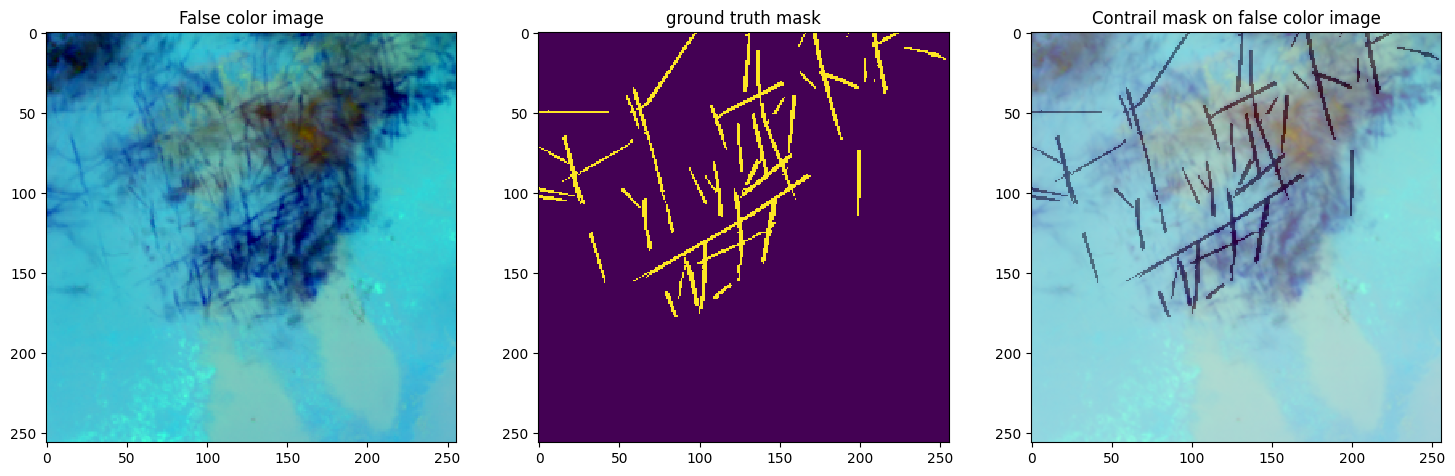

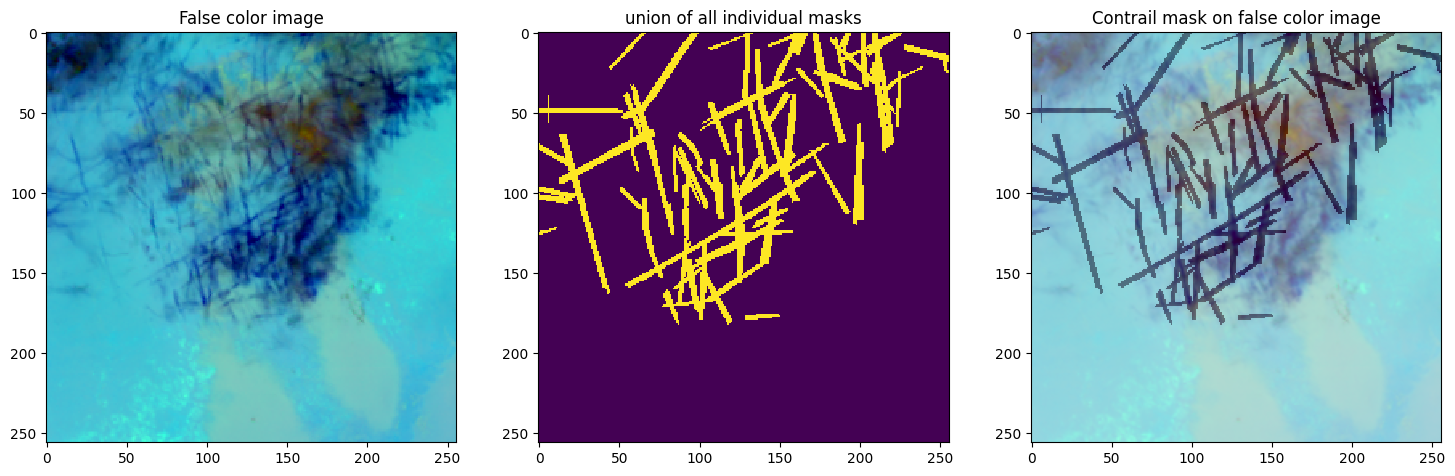

In [24]:
dataset_train = ContrailsDatasetMixed(split = "train",mode= "single", delta_t = 0)
normalized_img, [label_ground_truth, label_union] = dataset_train[0]
# reverse normalization
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
reverse_normalization = T.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
img = np.clip(reverse_normalization(normalized_img),0,1)
for i in range(2):
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(img.permute(1,2,0), interpolation='none')
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(({0:label_ground_truth,1:label_union}[i]), interpolation='none')
    ax.set_title({0:"ground truth mask",1:"union of all individual masks"}[i])

    ax = plt.subplot(1, 3, 3)
    ax.imshow(img.permute(1,2,0))
    ax.imshow({0:label_ground_truth,1:label_union}[i], cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

## Lightning Module Custom Tversky Loss
This Lightning module implements the custom loss function as described above in ```Implementation/custom loss```. 
The hyperparameters for the loss function are set in the config dictionary, but changed via the training function parameter.

In [ ]:
class LightningModuleTrLoss(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # print(config["aux_params"])
        self.model = model = smp.Unet(
            encoder_name=config["encoder_name"],
            encoder_depth=config["encoder_depth"],
            decoder_channels = (256, 128, 64, 32,16)[:config["encoder_depth"]],
            # aux_params = config["aux_params"],
            decoder_attention_type =config["decoder_attention_type"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []
        self.alpha = config["alpha"]
        self.beta = config["beta"]
        self.alpha_union = config["alpha_union"]
        self.beta_union = config["beta_union"]

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"][self.config["scheduler"]["name"]],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}


    def training_step(self, batch, batch_idx):
        imgs, [label_gt,label_union] = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss_ground_truth = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha, beta=self.beta, gamma=1.0)(preds, label_gt)
        loss_union = smp.losses.TverskyLoss("binary", classes=None, log_loss=False, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-06, alpha=self.alpha_union, beta=self.beta_union, gamma=1.0)(preds, label_union)
        loss = torch.mul(loss_ground_truth,self.config["weight_ground_truth"])+torch.mul(loss_union, self.config["weight_union"])
        self.log('loss_union', float(loss_union) , on_step=False, on_epoch=True, prog_bar=True) #, batch_size=16
        self.log('loss_ground_truth', float(loss_ground_truth) , on_step=False, on_epoch=True, prog_bar=True)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

## Function for training the model with specific hyperparamters

The `sample_loss_parameters` function can be used to train the model with different hyperparameters. The performance is tracked via the `csv_logger` and can later be plotted to compare the performance of the model on the validation dataset.
(As noted in the config file, I use max_epochs = 25.)

In [ ]:
def sample_loss_parameters(delta, cfg, module,alpha, alpha_union, weight_ground_truth):
    cfg['model']["alpha"] = alpha
    cfg['model']["beta"] = 1-alpha
    cfg['model']["alpha_union"] = alpha_union
    cfg['model']["beta_union"] = 1-alpha_union
    cfg['model']["weight_ground_truth"] = weight_ground_truth
    cfg['model']["weight_union"] = 1-weight_ground_truth
    identifier = "resnest26d_alpha="+str(alpha)+"_alpha_union="+str(alpha_union)+"_weight_ground_truth="+str(weight_ground_truth)
    dataset_train = ContrailsDatasetMixed("train", "single",delta)
    dataset_validation = ContrailsDatasetMixed("validation","single", delta)
    
    data_loader_train = DataLoader(
    dataset_train,
    batch_size=cfg["train_bs"],
    shuffle=True,
    num_workers=cfg["workers"],
    )
    
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=cfg["valid_bs"],
        shuffle=False,
        num_workers=cfg["workers"],
    )
    
    checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=cfg["output_dir"],
    mode="max",
    filename= identifier,
    save_top_k=1,
    verbose=1,
    )
    
    progress_bar_callback = TQDMProgressBar(
    refresh_rate=cfg["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**cfg["early_stop"])
    csv_logger = CSVLogger(cfg["output_dir"], name=identifier)
    trainer = L.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback], logger = csv_logger,
        **cfg["trainer"],
    )
    
    # cfg["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/cfg["trainer"]["devices"]
    model = module(cfg["model"])
    
    trainer.fit(model, data_loader_train, data_loader_validation)
    
    

## Sampling Hyperparameters
### Recap: model evaluation
The models in this Kaggle competition were evaluated with the $F_1$ score on the ground truth mask.   
As such, our goal is to perfom best on this metric. Due to that, we always keep our loss function for the validation dataset fixed to the $F_1$ score on the ground truth mask and evaluate the hyperparameters (via model performance) with that.
### Baseline & Reference

**B1)** The model trained with $F_1$ Loss on the ground truth only (disregarding the union_mask)     
acts as our baseline, as the training loss uses the same metric ($F_1$ Score on ground truth mask) on which we will later evaluate the model.
This is equivalent to using the following hyperparameters in the new loss:     
$\alpha = 0.5,  \alpha_{\text{union}} = 0.5, weight_{\text{ground-truth}} = 1$     

**R1)** Additionally, let's test the extreme interpretation of my idea     
by using as loss function the F1 loss on the ground_truth, and additionally only punishing false positives outside of the union_mask with another loss and then combining both losses.   
This can be achived with the following hyperparameters:    
$\alpha = 0.5,  \alpha_{\text{union}} = 1$    

Let's equally weight the losses:$weight_{\text{ground-truth}} = 0.5$   

To train and log the losses of **B1** and **R1**, I used the following code:
     

In [ ]:
# # B1
# sample_loss_parameters(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = 0.5,alpha_union = 0.5, weight_ground_truth = 1)

# # R1
# sample_loss_parameters(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = 0.5,alpha_union = 1, weight_ground_truth = 0.5)

## Results of baseline.

In [24]:

def get_best_validation_score(alpha, alpha_union,weight_ground_truth):
    path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
    maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]#[["val_dice","epoch"]]
    best_epoch_text = "Max val score is "+ "{:.3f}".format(maximum) + f"  For alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
    return best_epoch_text

**The baseline model B1**, which only utilizes the $F_1$ loss on the ground truth mask in training, achieved the following $F_1$ score on the validation set in its best epoch:

In [25]:
print(get_best_validation_score(alpha = 0.5, alpha_union = 0.5,weight_ground_truth = 1))

Max val score is 0.613  For alpha=0.5_alpha_union=0.5_weight_ground_truth=1


**The extreme interpretation R1**, which utilizes the union_mask to punish false positives only, achives the following score:


In [26]:
print(get_best_validation_score(alpha = 0.5, alpha_union = 1,weight_ground_truth = 0.5))

Max val score is 0.603  For alpha=0.5_alpha_union=1_weight_ground_truth=0.5


#### Let's see how much we can improve upon our baseline B1 if we *implement the idea in a more nuanced way than R1*.    
For that, I want to:   
 
Sample  from $\alpha_{\text{union}}$ parameters which punish false positives of the union_mask more than false negatives. So, let's sample around $\alpha_{\text{union}} 0.7$.    

For alpha, I expect the $F_1$ score(=$\alpha = 0.5$) to perform best, which punishes false-positives and false negatives equally. However, I still want to sample around this value.      

Due to measuring the performance of the model on the $F_1$ score on the ground truth, I want the combined loss function to focus on minimizing the loss on the ground_truth_mask. As such, I want to sample around  $weight_{ground-truth} = 0.65$


## Sample tversky parameter and weight
I used this code to train the models:

In [ ]:
for weight_ground_truth in [0.6,0.7]:
    for alpha in [0.35,0.5,0.65]:
        for alpha_union in [0.4,0.6,0.8]:
            # sample_loss_parameters(0, resnest26d_ash_attention_sample_loss, LightningModuleTrLoss, alpha = alpha,alpha_union = alpha_union, weight_ground_truth = weight_ground_truth)

### Functions to Visualize the results


In [20]:
def visualize_maxima_surface(weight_ground_truth, all_alpha, all_alpha_union):
    print("weight_ground_truth=",weight_ground_truth)
                            
    fig = plt.figure(figsize=(10,10))
    data = []
    for alpha in all_alpha:
        for alpha_union in all_alpha_union:
            path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
            metrics = pd.read_csv(path)
            metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
            maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]
            data += [[alpha, alpha_union, maximum]]

    x = [i[0] for i in data]
    y = [i[1] for i in data]
    z = [i[2] for i in data]
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y)
    Z = griddata((x,y), z, (X,Y), method='cubic')
    ax.scatter(x,y,z,c=z,cmap='coolwarm', alpha=1)
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [0.613, z[i]], color='black', alpha=0.5)

    # Plot the surface
    ax.set_xlabel('alpha')
    ax.set_ylabel('alpha_union')
    ax.set_zlabel('maximum')

    plt.show()

    # baseline loss function for reference
    path = f"metrics/resnest26d_alpha=0.5_alpha_union=0.5_weight_ground_truth=1/version_0/metrics.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
    maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]
    print(f"BASELINE: {maximum:.3f} (DICE LOSS on ground truth mask)")

def visualize_epochs_graphs(hyperparameters):
    
    plt.figure(figsize=(15,20))
    for parameter in hyperparameters:
        weight_ground_truth, alpha, alpha_union = parameter["weight_ground_truth"], parameter["alpha"], parameter["alpha_union"]
        path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
        metrics = pd.read_csv(path)

        metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
        maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]

        label = f"max: {maximum:.3f} | alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}"
        linestyle = {0.6:"--",0.7:"-"}[weight_ground_truth]
        plt.plot(metrics['val_dice'], label=label, linestyle = linestyle)
        print(label)

    # -- same as above, but for baseline
    path = f"metrics/resnest26d_alpha=0.5_alpha_union=0.5_weight_ground_truth=1/version_0/metrics.csv"
    metrics = pd.read_csv(path)
    metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
    maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]
    label = f"max: {maximum:.3f} | alpha=0.5_weight_ground_truth=1 (=DICE LOSS)"
    linestyle, color = "dashdot", (0,0,0)
    plt.plot(metrics['val_dice'], label=label, linestyle = linestyle, color = color)
    print(label)

    plt.legend()
    plt.show()

def return_n_best_hyperparameters(n):
    parameter_text_and_parameters = []
    all_alpha = [0.35,0.5,0.65]
    all_alpha_union = [0.4,0.6,0.8]
    all_weight_ground_truth = [0.6,0.7]
    for weight_ground_truth in all_weight_ground_truth:
        for alpha in all_alpha:
                for alpha_union in all_alpha_union:
                    path = f"metrics/resnest26d_alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}/version_0/metrics.csv"
                    metrics = pd.read_csv(path)
                    metrics = metrics.dropna(subset = ['val_dice']).set_index("epoch")
                    maximum = metrics.dropna(subset = ['val_dice']).max()["val_dice"]

                    parameter_text_and_parameters += [[f"max: {maximum:.3f} | alpha={alpha}_alpha_union={alpha_union}_weight_ground_truth={weight_ground_truth}", {"weight_ground_truth":weight_ground_truth, "alpha":alpha, "alpha_union":alpha_union}]]

    parameter_text_and_parameters.sort(reverse=True,key = lambda x: x[0])
    
    return [parameters[1] for parameters in parameter_text_and_parameters[:n]]

## Results
#### Visualizations

I have data of all combinations of the following hyperparameter values:
```
alpha = [0.35,0.5,0.65]      
alpha_union = [0.4,0.6,0.8]    
weight_ground_truth = [0.6,0.7]
```

To visualize how the choice of hyperparameter influences performance, I try to approximate the score surface of the $max\_dice\_score(\alpha_{union}, \alpha)$ by creating a scatter plot for each $weight_{ground-truth}$  value, such that I can see which hyperparameter configurations work the best and where maxima could be expected.


weight_ground_truth= 0.7


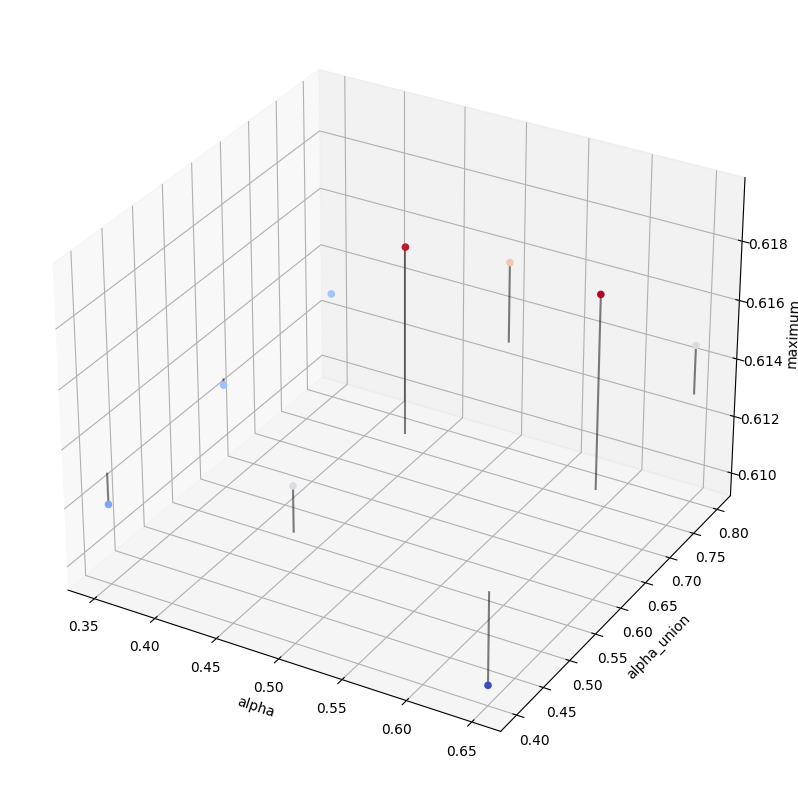

BASELINE: 0.613 (DICE LOSS on ground truth mask)



weight_ground_truth= 0.6


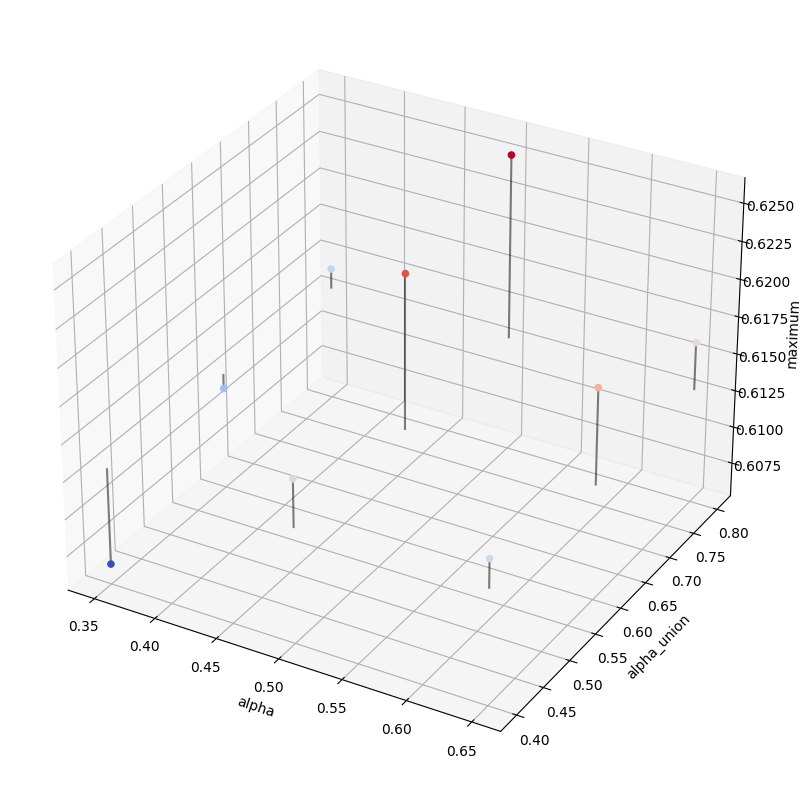

BASELINE: 0.613 (DICE LOSS on ground truth mask)


In [14]:
alpha = [0.35,0.5,0.65]
alpha_union = [0.4,0.6,0.8]


weight_ground_truth = 0.7
visualize_maxima_surface(weight_ground_truth, alpha, alpha_union)
print ("\n\n")
weight_ground_truth = 0.6
visualize_maxima_surface(weight_ground_truth, alpha, alpha_union)



Interestingly, with $weight_{\text{ground-truth}}= 0.7$, the surface structure is different to  $weight_{\text{ground-truth}}= 0.6$. 
While both share the "ridgeline" along $\alpha= 0.5$, for $weight_{\text{ground-truth}}= 0.6$, $\alpha=0.65$ performs much better in comparison, there even seems to be a small "ridgeline" along $alpha_{union} = 0.65$.      
If I wanted to test further values, I would try to sample from the approximated ridgelines to check for better performing hyperparameters. 


Let's now look at the best performing hyperparameters in detail. 

max: 0.625 | alpha=0.5_alpha_union=0.8_weight_ground_truth=0.6
max: 0.623 | alpha=0.5_alpha_union=0.6_weight_ground_truth=0.6
max: 0.619 | alpha=0.65_alpha_union=0.6_weight_ground_truth=0.7
max: 0.619 | alpha=0.65_alpha_union=0.6_weight_ground_truth=0.6
max: 0.619 | alpha=0.5_alpha_union=0.6_weight_ground_truth=0.7
max: 0.613 | alpha=0.5_weight_ground_truth=1 (=DICE LOSS)


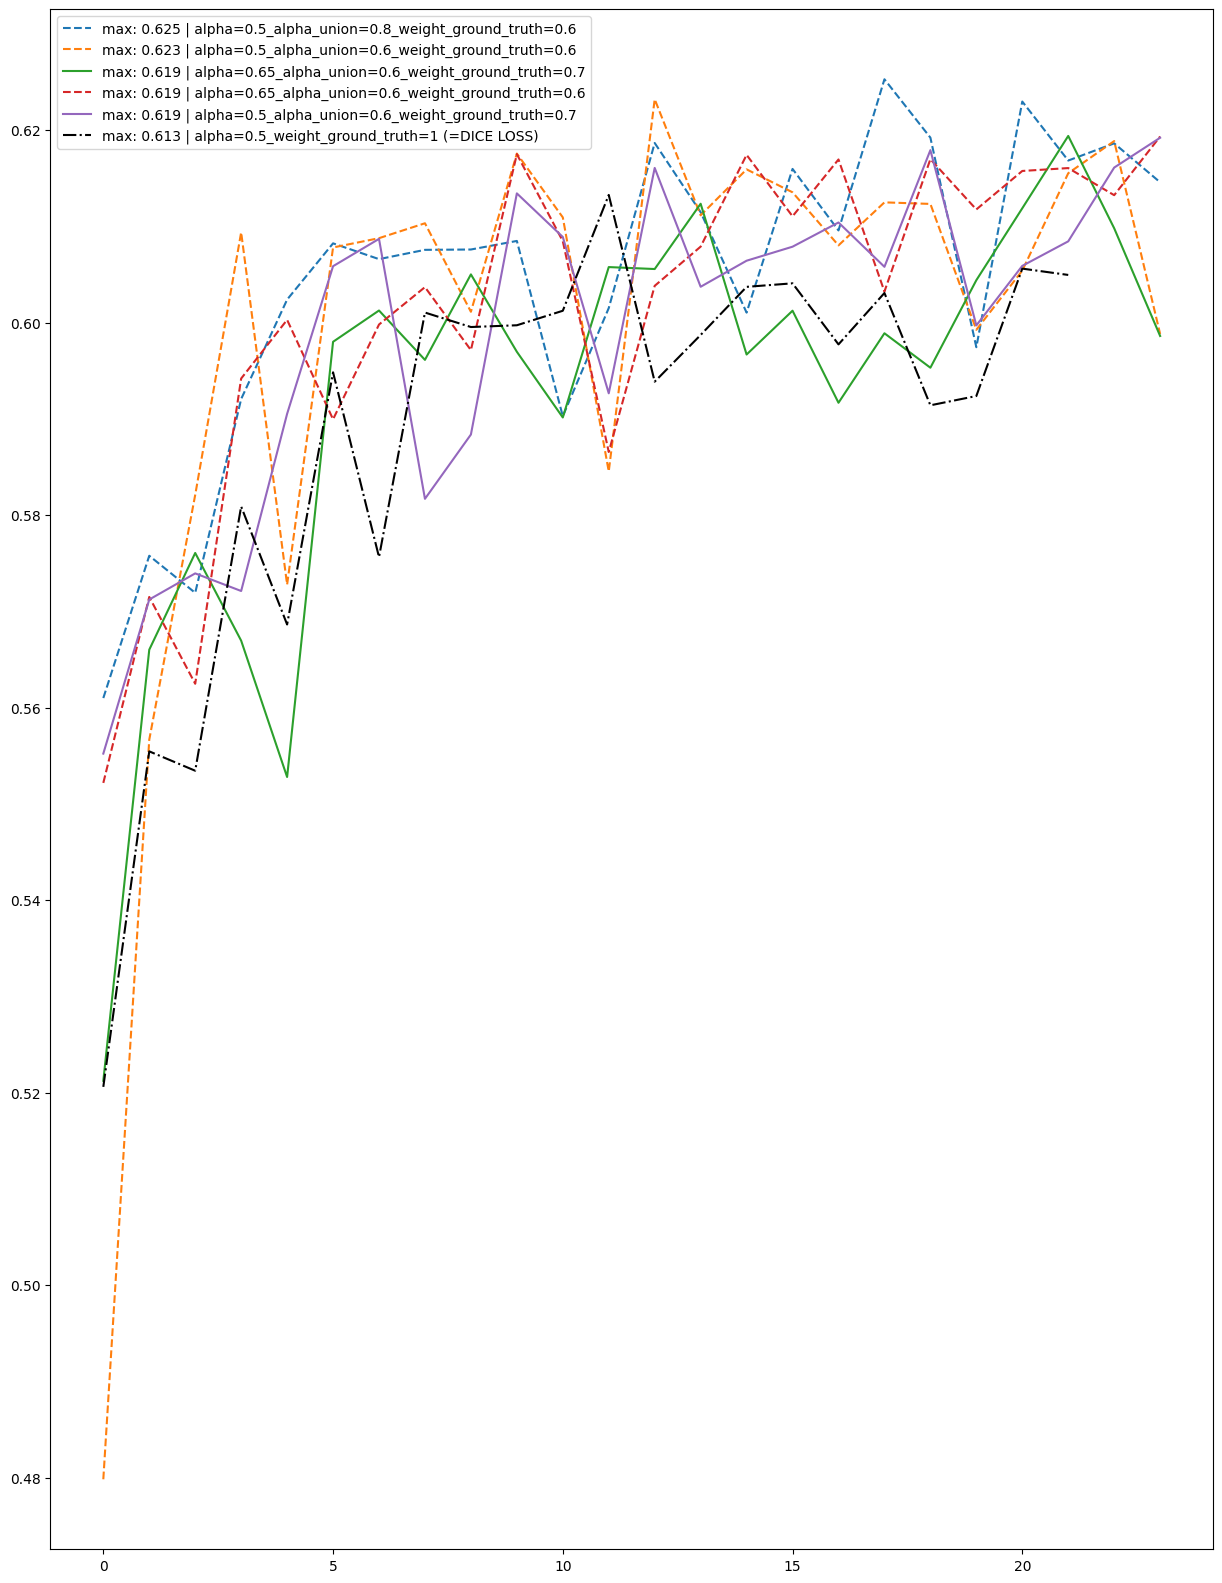

In [21]:
parameters = return_n_best_hyperparameters(5)

visualize_epochs_graphs(parameters)

max: 0.625 | alpha=0.5_alpha_union=0.8_weight_ground_truth=0.6
max: 0.623 | alpha=0.5_alpha_union=0.6_weight_ground_truth=0.6
max: 0.613 | alpha=0.5_weight_ground_truth=1 (=DICE LOSS)


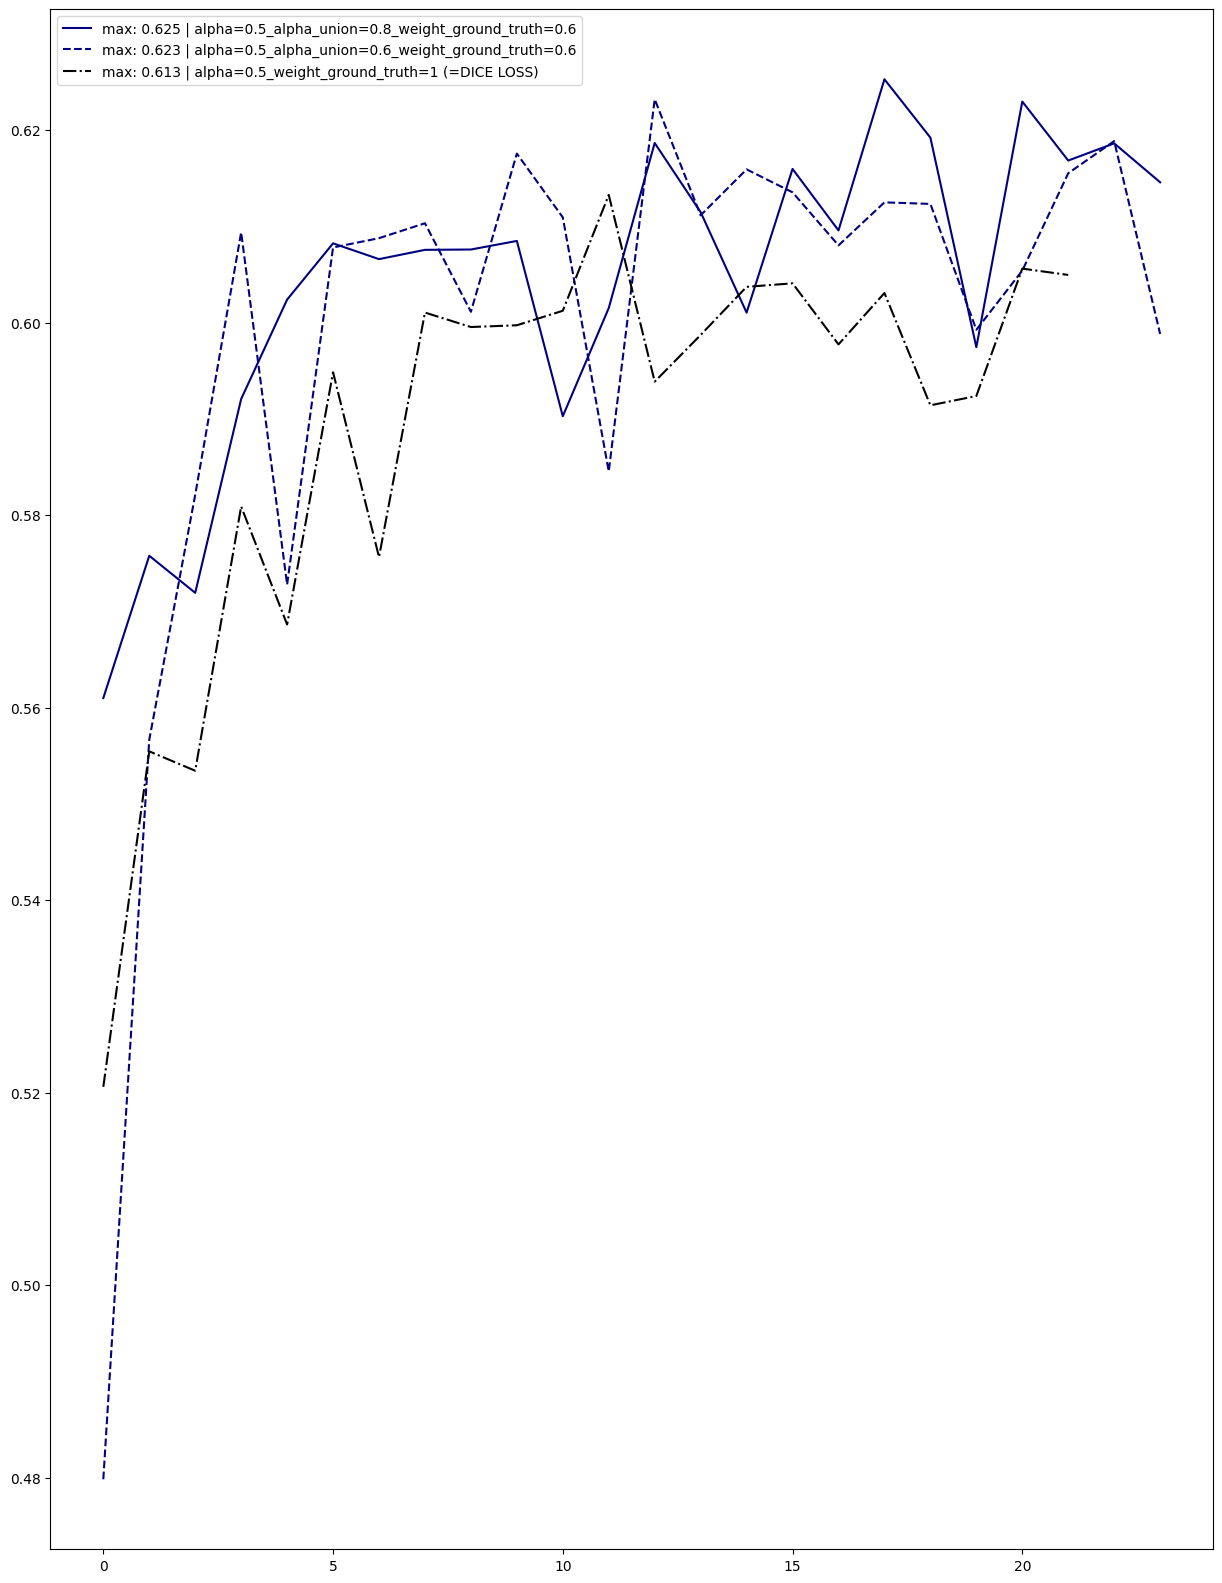

In [9]:
parameters = return_n_best_hyperparameters(2)

visualize_epochs_graphs(parameters)

We can see that the model is able to learn for more epochs. While the baseline looks to start overfitting after epoch 12, the best performing model with the adjusted loss continues to improve its validation score until around epoch 17. 
The model with $\alpha=0.5, \alpha_{union}=0.6,weight_{ground.truth}=0.7$ might continue to improve even further, as the best perfoming epoch is 25.    

#### Conclusion
Although the adjusted loss only improved the validation score from 0.613 to 0.625, it is a hint that incorporating the individual labels can lead to an improved performance.  
This was confirmed after the end of the competition, when the winners of the competition shared their model, which utilized all the individual labels. However, they used a more nuanced approach, where they trained the model to predict per pixel how many percent of the labelers marked it as a contrail.